# Zadanie obejmuje następujące kroki
1. Wybór białka (HNRNPC/HNRNPA2B1) analizowanego podczas eksperymentów, co jednoznacznie identyfikuje wykorzystywany zestaw danych.
2. Zapoznanie się z motywem oczekiwanym, wyekstrahowanym na podstawie eksperymentalnie określonej struktury 3D kompleksu, utworzonego przez analizowane białko wiążące z RNA, w celu identyfikacji liczby wchodzących w jego skład nukleotydów (len). Załóżmy, że nasz motyw oczekiwany to TTTT, wtedy len = 4.
3. Określenie długości potencjalnie obiecujących motywów w = {len, len + 1, len + 2}. Załóżmy, że nasz motyw oczekiwany to TTTT (len = 4), wtedy len + 1 = {NTTTT, TTTTN}, a len + 2 = {NTTTTN}, gdzie N to dowolny nukleotyd.
4. Ekstrakcja wszystkich obiecujących, ciągłych motywów (reprezentowanych przez odpowiadające im profile danych fSHAPE) o długości w = len … len + 2 spełniających założoną charakterystykę miejsca wiązania, w oparciu o wartości współczynnika reaktywności uzyskane metodą fSHAPE (tzn. wartość reaktywności dla przynajmniej jednego nukleotydu w ramach motywu musi przekraczać wartość 1.0), spośród krótkich fragmentów transkryptów zawartych w archiwum identyfikator_wybranego_białka_binding_sites_fshape.zip, które prawdopodobnie zawierają nieodkryte dotąd miejsca wiązań RNA z rozpatrywanym białkiem.
5. Przeprowadzenie analizy skupień z wykorzystaniem przynajmniej dwóch metod (np. KMEANS++, DBSCAN, itd.) dla zbioru motywów wyekstrahowanych w poprzednim kroku dla każdej długości motywu (w) analizowanej niezależnie.
6. Wyznaczenie obiecującego motywu konsensusowego (np. z wykorzystaniem biblioteki STUMPY) na podstawie profili danych fSHAPE zawartych w trzech najbardziej licznych klastrach zidentyfikowanych w poprzednim kroku (przy czym minimalna moc klastra, dla którego należy wyznaczać motyw konsensusowy nie może być niższa niż 3). 
7. Przeprowadzenie przeszukiwania transkryptów (np. z wykorzystaniem biblioteki STUMPY), przechowywanych w archiwum identyfikator_wybranego_białka_ search_fshape.zip, na podstawie profili danych fSHAPE wyekstrahowanych dla obiecujących motywów konsensusowych zidentyfikowanych w poprzednim kroku oraz motywu oczekiwanego. Opracowanie rezultatów w postaci tabelarycznej, gdzie każdy motyw będzie opisany przez jego sekwencję, zakresy numerów nukleotydów, nazwę pliku transkryptu, w którym został zidentyfikowany oraz wartości następujących miar, a mianowicie znEd, ssf, aS wyznaczonych w kontekście motywu oczekiwanego. Rekordy powinny być uporządkowane w porządku niemalejącym według ostatniej kolumny (aS)


1. Wybór jednego z dwóch białek (HNRNPC/HNRNPA2B1) do analizy, co określa zestaw danych do użycia.
2. Zrozumienie i identyfikacja motywu oczekiwanego na podstawie struktury 3D RNA-białko, określając liczbę nukleotydów w motywie (np., dla TTTT, len = 4).
3. Określenie długości potencjalnie obiecujących motywów, które mogą być dłuższe o 1 lub 2 nukleotydy od motywu oczekiwanego.
4. Ekstrakcja motywów o zdefiniowanej długości z danych fSHAPE, które spełniają kryteria reaktywności (przynajmniej jeden nukleotyd z reaktywnością powyżej 1.0).
5. Przeprowadzenie analizy skupień dla wyekstrahowanych motywów przy użyciu co najmniej dwóch metod analizy skupień.
6. Identyfikacja motywu konsensusowego z wykorzystaniem danych fSHAPE dla trzech najliczniejszych klastrów, z minimalną wielkością klastra określoną na 3.
7. Przeszukiwanie transkryptów w celu znalezienia motywów odpowiadających obiecującemu motywowi konsensusowemu oraz motywowi oczekiwanemu, z wynikami przedstawionymi w tabeli opisującej sekwencję motywu, zakresy numerów nukleotydów, nazwę pliku transkryptu oraz wartości miar znEd, ssf, aS.

## Wybór białka

Wybór białka (HNRNPC/HNRNPA2B1) analizowanego podczas eksperymentów, co jednoznacznie identyfikuje wykorzystywany zestaw danych.
Zapoznanie się z motywem oczekiwanym, wyekstrahowanym na podstawie eksperymentalnie określonej struktury 3D kompleksu, utworzonego przez analizowane białko wiążące z RNA, w celu identyfikacji liczby wchodzących w jego skład nukleotydów (len). Załóżmy, że nasz motyw oczekiwany to TTTT, wtedy len = 4.

In [100]:
from src.datasets import DatasetLoader, Dataset, BindingSiteFrame, PatternFrame, SearchFrame
from dataclasses import dataclass
from src.utils import windows, flatten
from pandas import DataFrame
import os
from typing import TypedDict, Generator
import stumpy
from collections import Counter
import numpy as np
from numpy.typing import NDArray
from typing import Protocol
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering, MeanShift, SpectralClustering, Birch, HDBSCAN
from joblib import Parallel, delayed



## Dataset

### Pattern

plik tekstowy zawierający oczekiwany motyw skojarzony z miejscem wiązania RNA-białko wyznaczony dla określonego kompleksu na podstawie eksperymentalnie określonej struktury przestrzennej (uśredniona liczba wiązań wodorowych dla nukleotydów rozpatrywanych w ramach miejsc wiązań z białkami koreluje z ich wysoką reaktywnością wyznaczoną metodą fSHAPE). Plik zawiera dane w postaci tabelarycznej (bez nagłówka) obejmując następujące kolumny (oddzielone tabulatorami), a mianowicie wartość współczynnika fSHAPE oraz nazwę zasady (A/C/T/G).

### Sites

archiwum obejmujące zestaw krótkich fragmentów transkryptów służących do odkrywania powtarzalnych wzorców stanowiących konsensus, które mogą stanowić nieznane dotąd, potencjalnie obiecujące miejsca wiązań z rozpatrywanym białkiem. Każdy plik zawiera dane w postaci tabelarycznej (bez nagłówka) obejmując następujące kolumny (oddzielone tabulatorami), a mianowicie wartość współczynnika fSHAPE, nazwę zasady (A/C/T/G) oraz opcjonalnie wartość współczynnika SHAPE.

### Searches

archiwum obejmujące zestaw transkryptów,
które będą przeszukiwane z wykorzystaniem konserwatywnego(ych) motywu(ów)
odkrytego(ych) w poprzednim kroku w celu identyfikacji motywów charakteryzujących
się zbliżonym profilem danych fSHAPE (z-normalized Euclidean distance nie powinien
przekraczać wartości 2.5) oraz wysokim współczynnikiem podobieństwa sekwencyjnego. 


In [78]:
dataset = DatasetLoader.hnrnpa2b1()
dataset.pattern.fillna("N", inplace=True)


[memo::read-406c9d...] Loading from memory.


## Zapoznanie się z motywem oczekiwanym oraz określenie jego długości


Określenie długości potencjalnie obiecujących motywów w = {len, len + 1, len + 2}. Załóżmy, że nasz motyw oczekiwany to TTTT (len = 4), wtedy len + 1 = {NTTTT, TTTTN}, a len + 2 = {NTTTTN}, gdzie N to dowolny nukleotyd.

In [79]:
@dataclass
class Motif(object):
  pattern: str

  def __len__(self):
    return len(self.pattern)

  def neighbors(self, n: int) -> list['Motif']: return [
    self.__class__("N" * left + self.pattern + "N" * (n - left))
    for left in range(n + 1)
    if abs(left + left - n) <= 1
  ]

  def __str__(self):
    return ''.join(self.pattern)

  def __hash__(self):
    return hash(self.pattern)

In [80]:
expected_motif = Motif(''.join(dataset.pattern.base))

print(expected_motif)
print(f"Długość: {len(expected_motif)}")

NNAGGNNTAGN
Długość: 11


## Określenie długości potencjalnie obiecujących motywów oraz ekstrakcja motywów

Ekstrakcja wszystkich obiecujących, ciągłych motywów (reprezentowanych przez
odpowiadające im profile danych fSHAPE) o długości w = len … len + 2 spełniających
założoną charakterystykę miejsca wiązania, w oparciu o wartości współczynnika
reaktywności uzyskane metodą fSHAPE (tzn. wartość reaktywności dla przynajmniej
jednego nukleotydu w ramach motywu musi przekraczać wartość 1.0), spośród krótkich
fragmentów transkryptów zawartych w archiwum *identyfikator_wybranego_białka_binding_sites_fshape.zip*, które prawdopodobnie
zawierają nieodkryte dotąd miejsca wiązań RNA z rozpatrywanym białkiem.

In [81]:
def same_as(sequence: BindingSiteFrame, motif: Motif) -> bool: return all(
  a == b or b == "N"
  for a, b in zip(sequence.base, motif.pattern)
)

def is_sequence_promising(sequence: BindingSiteFrame, any_threshold: float = None, all_threshold: float = None) -> bool:
  return not sequence.reactivity.isnull().values.any() \
    and (any_threshold is None or any(sequence.reactivity > any_threshold)) \
    and (all_threshold is None or all(sequence.reactivity > all_threshold))

def extract_motifs(dataset: Dataset, size: int, *, any_threshold: float = None, all_threshold: float = None) \
    -> list[BindingSiteFrame]:
  sequence: BindingSiteFrame

  return [
    sequence
    for site in dataset.sites
    for sequence in windows(site, size)
    if is_sequence_promising(sequence, any_threshold, all_threshold)
  ]

sequences_map = {
  size: extract_motifs(dataset, size, any_threshold=1.0)
  for size in [len(expected_motif) + i for i in range(3)]
}


In [82]:
sequences_frames = {
  size: DataFrame.from_dict({
    "sequence": [''.join(s.base) for s in sequences],
    "reactivity": [s.reactivity.tolist() for s in sequences]
  })
  for size, sequences in sequences_map.items()
}


In [83]:
for sequence_size, sequences in sequences_frames.items():
  print(f"Potencjalne motywy o długości {sequence_size}: {len(sequences)}")


Potencjalne motywy o długości 11: 1573
Potencjalne motywy o długości 12: 1624
Potencjalne motywy o długości 13: 1669


## Analiza skupień

Przeprowadzenie analizy skupień z wykorzystaniem przynajmniej dwóch metod (np. KMEANS++, DBSCAN, itd.) dla zbioru motywów wyekstrahowanych w poprzednim kroku dla każdej długości motywu (w) analizowanej niezależnie.

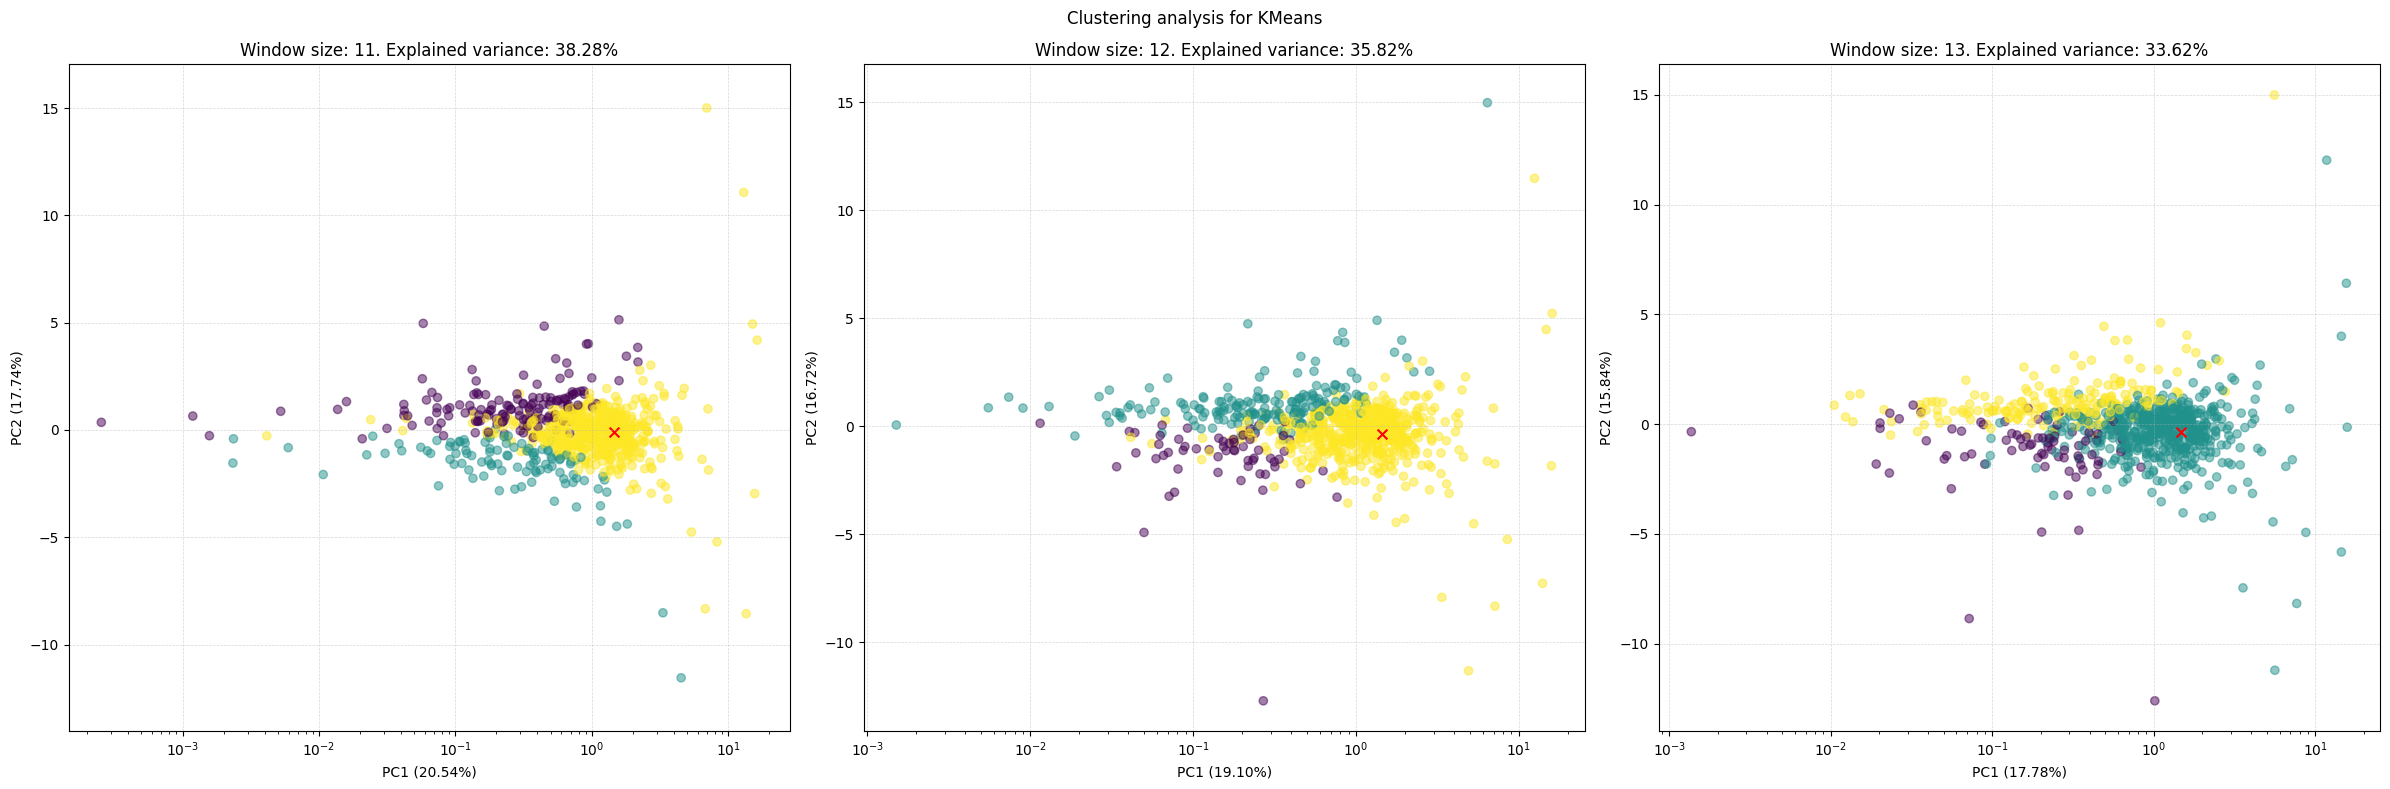

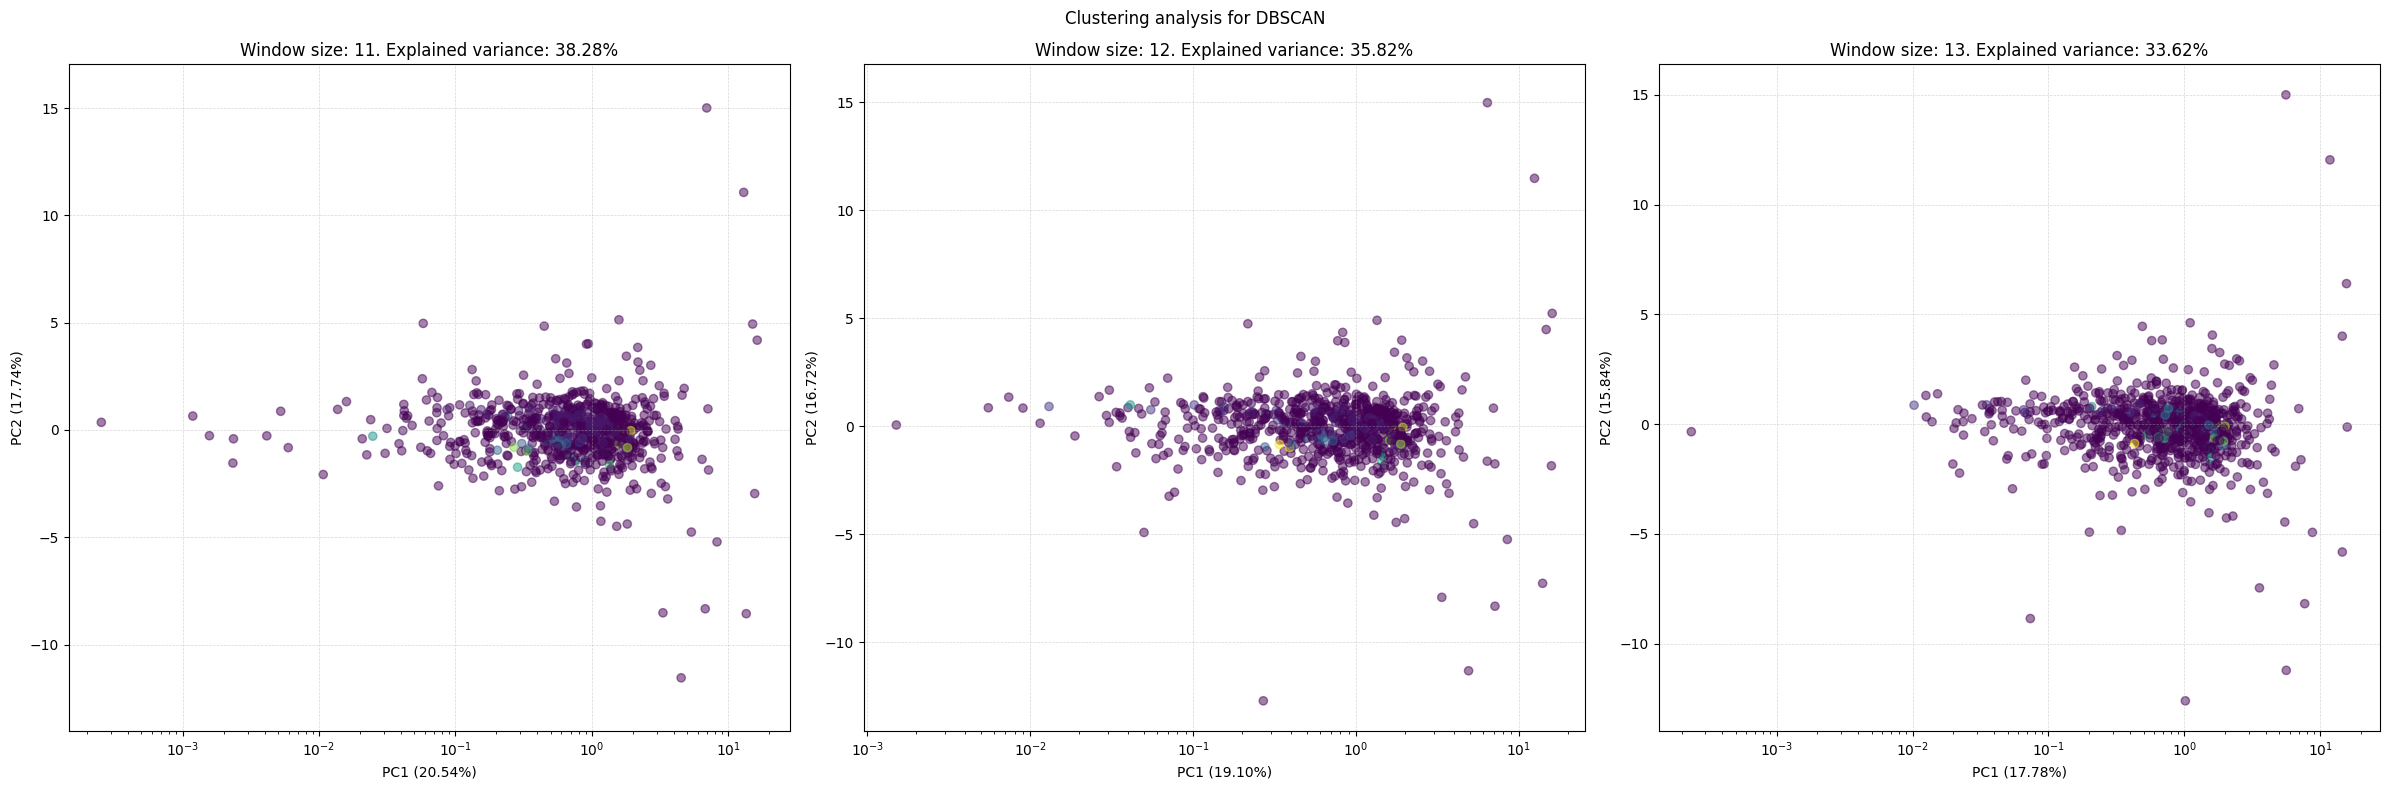

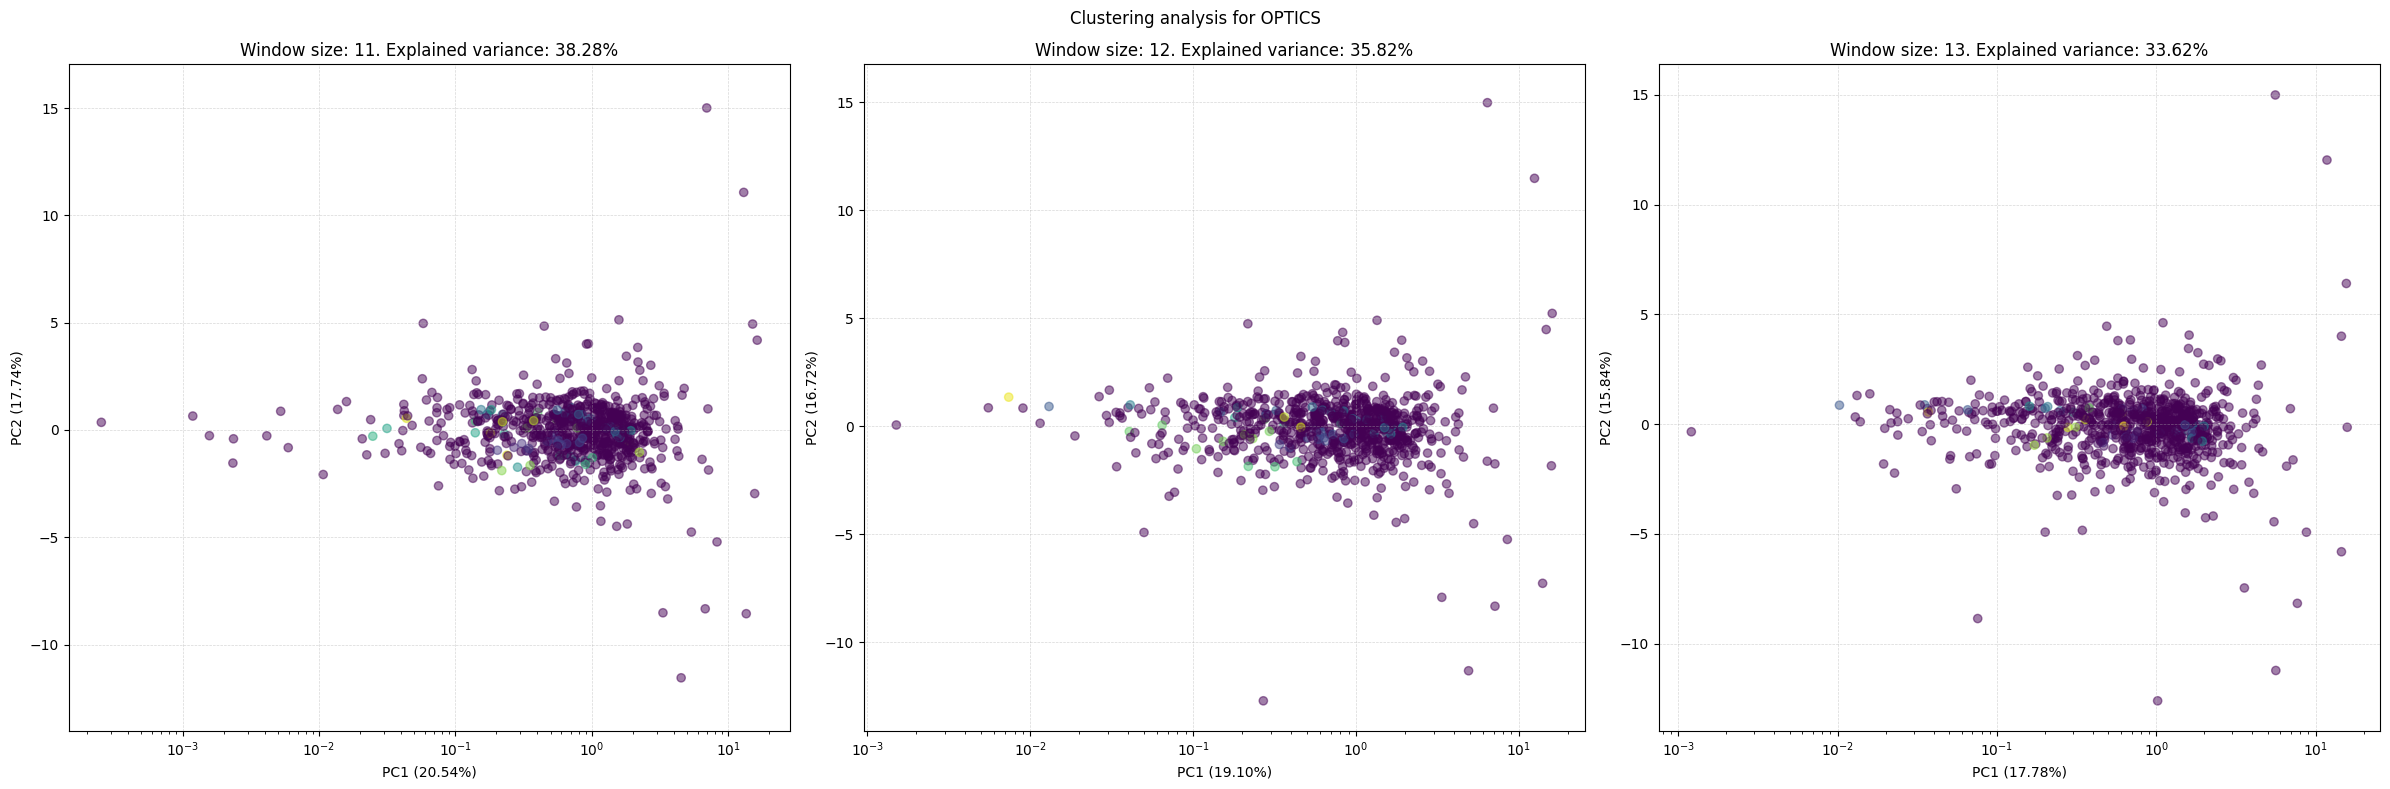

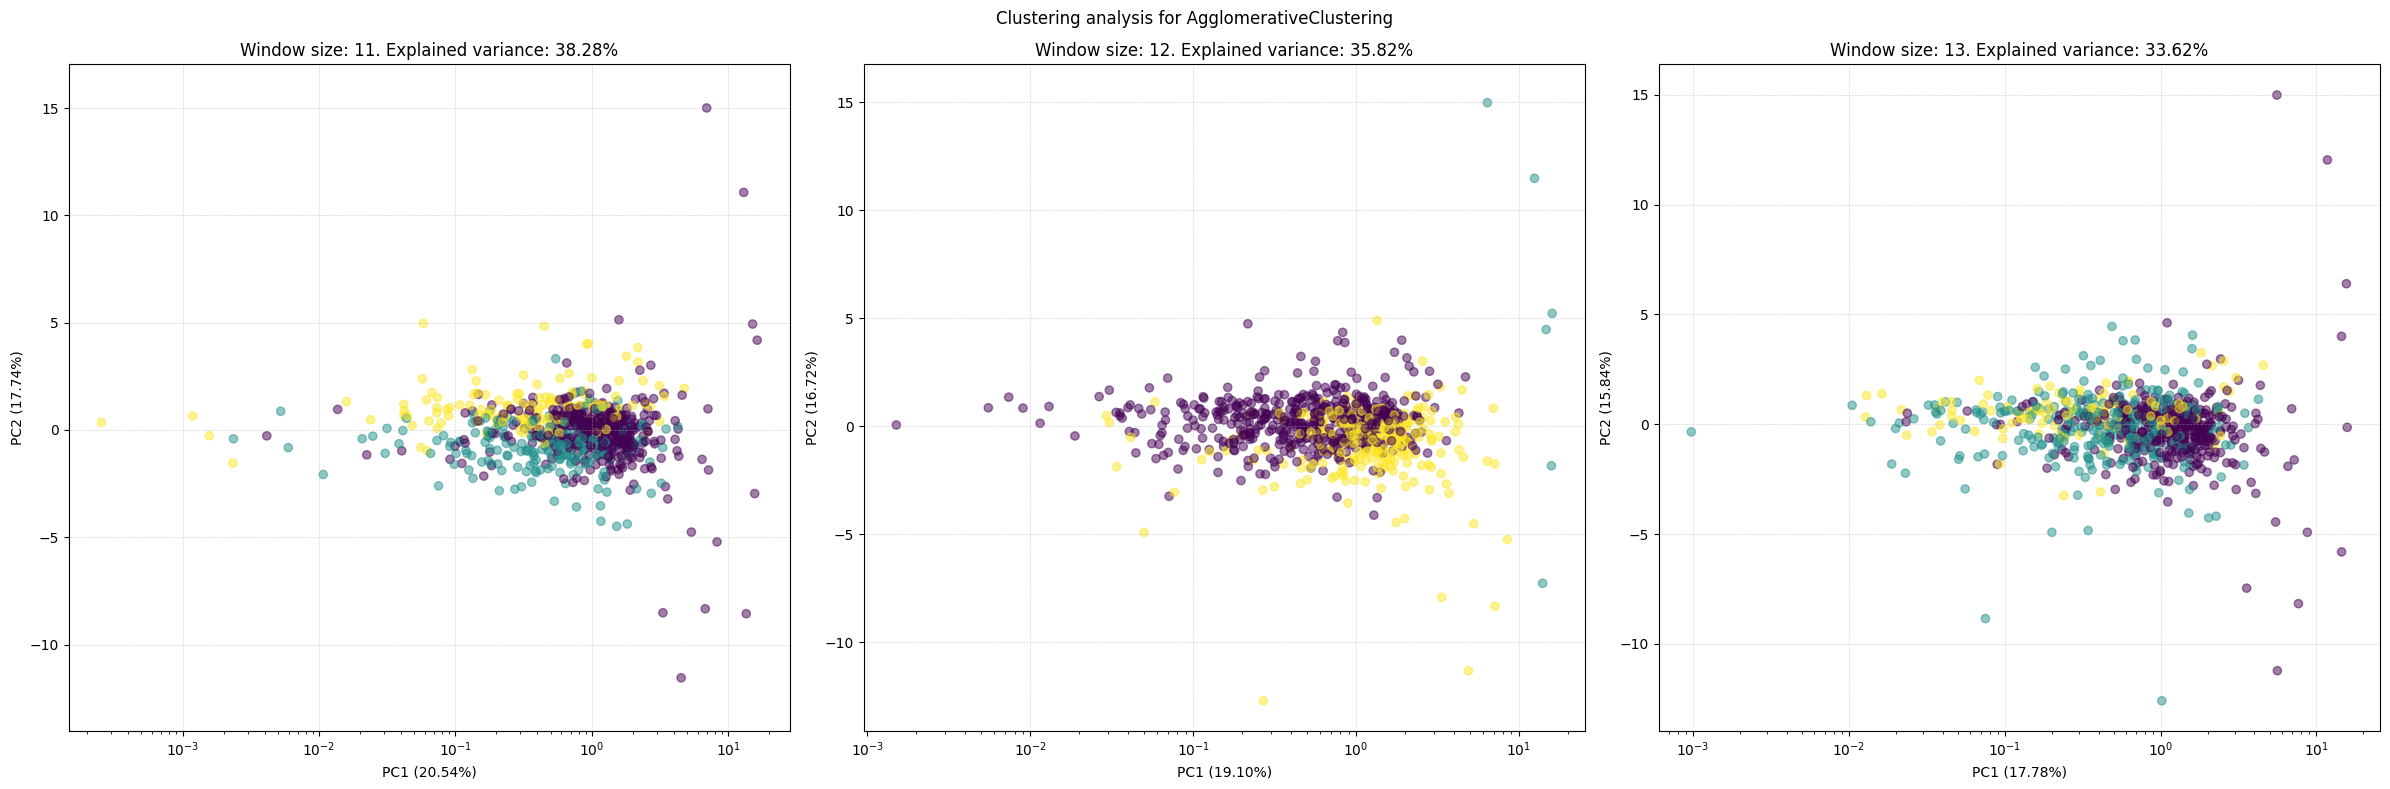

In [130]:

def analyze_clusters(model: KMeans | DBSCAN | OPTICS | AgglomerativeClustering | SpectralClustering | Birch | HDBSCAN,
                     sequences_frames: dict[int, DataFrame]):
  figure, axes = plt.subplots(1, len(sequences_frames), figsize=(24, 8), tight_layout=True)
  name = model.__class__.__name__

  pca = PCA(n_components=2)
  for axis, (length, frame) in zip(axes, sequences_frames.items()):
    x = np.array(frame.reactivity.tolist())
    predicted = model.fit_predict(x)
    points = pca.fit_transform(x)

    (pc1, pc2) = pca.explained_variance_ratio_
    axis.scatter(points[:, 0], points[:, 1], c=predicted, alpha=0.5)
    axis.set_title(f"Window size: {length}. Explained variance: {(pc1 + pc2) * 100:.2f}%")

    axis.set_xlabel(f"PC1 ({pc1 * 100:.2f}%)")
    axis.set_ylabel(f"PC2 ({pc2 * 100:.2f}%)")
    axis.grid(linestyle="--", linewidth=0.5, alpha=0.5)
    axis.set_xscale("log")

    if isinstance(model, KMeans):
      centers = pca.transform(model.cluster_centers_)
      axis.scatter(centers[:, 0], centers[:, 1], marker="x", color="red", s=50)

  plt.suptitle(f"Clustering analysis for {name}")
  plt.show()

models = {
  "KMeans++": KMeans(n_clusters=3, init="k-means++"),
  "DBSCAN": DBSCAN(eps=0.8, min_samples=3),
  # "HDBSCAN": HDBSCAN(min_cluster_size=3),
  "OPTICS": OPTICS(min_samples=3),
  # "OPTICS_dbscan": OPTICS(min_samples=3, cluster_method="dbscan"), # 18
  # "OPTICS_min": OPTICS(min_samples=3, min_cluster_size=100),
  "Agglomerative": AgglomerativeClustering(n_clusters=3),
  # "Spectral": SpectralClustering(n_clusters=3),
  # "Birch": Birch(n_clusters=3)
}

for name, model in models.items():
  analyze_clusters(model, sequences_frames)


## Wyznaczenie motywu konsensusowego

Wyznaczenie obiecującego motywu konsensusowego (np. z wykorzystaniem biblioteki STUMPY) na podstawie profili danych fSHAPE zawartych w trzech najbardziej licznych klastrach zidentyfikowanych w poprzednim kroku (przy czym minimalna moc klastra, dla którego należy wyznaczać motyw konsensusowy nie może być niższa niż 3).


In [148]:
def find_densest_clusters(labels: NDArray, *, n_clusters: int) -> list[tuple[int, int]]:
  counts = Counter(labels)
  counts.pop(-1, None)
  return counts.most_common(n_clusters)

def find_consensus(dataset: Dataset, expected: Motif, sequences_frames: dict[int, DataFrame]) -> DataFrame:
  consensus_reactivities = [dataset.pattern.reactivity.to_numpy()]
  consensus_sequences = [expected.pattern]

  for size, frame in sequences_frames.items():
    reactivities = np.array(frame.reactivity.values.tolist())
    sequences = np.array(frame.sequence.values.tolist())

    clusters = models["Agglomerative"].fit_predict(reactivities)
    densest_clusters = find_densest_clusters(clusters, n_clusters=3)

    cluster_labels = [label for label, _ in densest_clusters]
    cluster_indices = [stumpy.ostinato(reactivities[clusters == label].tolist(), size)[1] for label in cluster_labels]

    for label, index in zip(cluster_labels, cluster_indices):
      consensus_reactivities.append(reactivities[clusters == label][index])
      consensus_sequences.append("".join(sequences[clusters == label][index]))

    print(f"Window size: {size}. Densest clusters: {densest_clusters}")
    for label, index in zip(cluster_labels, cluster_indices):
      print(f"Consensus motif for cluster {label}: {''.join(sequences[clusters == label][index])}")

  return DataFrame.from_dict({
    "sequence": consensus_sequences,
    "reactivity": consensus_reactivities
  })

consensus_frame = find_consensus(dataset, expected_motif, sequences_frames)
consensus_frame

Window size: 11. Densest clusters: [(1, 648), (2, 492), (0, 433)]
Consensus motif for cluster 1: ATCCAGTGACT
Consensus motif for cluster 2: AGAACCAATTT
Consensus motif for cluster 0: TGACGGCTACT
Window size: 12. Densest clusters: [(0, 1311), (2, 305), (1, 8)]
Consensus motif for cluster 0: CCAGTGACTAAA
Consensus motif for cluster 2: ATAGACGGAATT
Consensus motif for cluster 1: GTGCTAATGGTG
Window size: 13. Densest clusters: [(1, 799), (2, 458), (0, 412)]
Consensus motif for cluster 1: GCTGTTAGGTTGC
Consensus motif for cluster 2: GAAGTAATTTTGT
Consensus motif for cluster 0: TAGCATCTCAGCA


,sequence,reactivity
0,NNAGGNNTAGN,"[0.0, 1.0, 2.0, 3.0, 2.0, 0.0, 0.0, 1.0, 0.5, ..."
1,ATCCAGTGACT,"[-12.8092507445, -0.785009025632, -1.037995506..."
2,AGAACCAATTT,"[0.128867310414, 2.16303020472, -2.15318657402..."
3,TGACGGCTACT,"[1.76132069129, 0.0644204100748, 0.65944199273..."
4,CCAGTGACTAAA,"[-1.03799550619, -1.70003604295, 0.60886781914..."
5,ATAGACGGAATT,"[0.0315212514723, 1.22022811636, 1.11360248466..."
6,GTGCTAATGGTG,"[26.3755771069, 5.47446088628, -0.279028317373..."
7,GCTGTTAGGTTGC,"[-0.478659503583, -0.00885418892581, 0.3149608..."
8,GAAGTAATTTTGT,"[-0.654884923977, 1.0059523427, 3.50235621269,..."
9,TAGCATCTCAGCA,"[1.30766381105, 1.31992413765, 0.088819745325,..."


## Przeszukiwanie transkryptów - pomocnicze funkcje

In [149]:
def calculate_secondary_structure_factor(first: str, second: str) -> float:
  group_matches = ("AG", "CU", "CT")
  ssf_sum: int = 0
  for a, b in zip(first, second):
    if a == b or a == "N" or b == "N":
      ssf_sum += 2
      continue
    for group in group_matches:
      if a in group and b in group:
        ssf_sum += 1
        break
  return ssf_sum / len(first)

def calculate_motif_secondary_structure_factor(first: str, second: str) -> float:
  return max(
    calculate_secondary_structure_factor(second, first),
    calculate_secondary_structure_factor(second, reversed(first))
  )


def calculate_alignment_score(norm_edit_distance: float, secondary_structure_factor: float) -> float:
  return 10 * norm_edit_distance - secondary_structure_factor


def calculate_norm_edit_distance(first: NDArray, second: NDArray) -> float:
  return stumpy.core.mass(first, second)[0]


## Przeszukiwanie transkryptów - funkcja przeszukiwania

Przeprowadzenie przeszukiwania transkryptów (np. z wykorzystaniem biblioteki STUMPY), przechowywanych w archiwum identyfikator_wybranego_białka_ search _fshape.zip, na podstawie profili danych fSHAPE wyekstrahowanych dla obiecujących motywów konsensusowych zidentyfikowanych w poprzednim kroku oraz motywu oczekiwanego. Opracowanie rezultatów w postaci tabelarycznej, gdzie każdy motyw będzie opisany przez jego sekwencję, zakresy numerów nukleotydów, nazwę pliku transkryptu, w którym został zidentyfikowany oraz wartości następujących miar, a mianowicie znEd, ssf, aS wyznaczonych w kontekście motywu oczekiwanego. Rekordy powinny być uporządkowane w porządku niemalejącym według ostatniej kolumny (aS).

In [150]:

SearchResult = TypedDict("SearchResult", {
  "motif": str,
  "sequence": str,
  "start": int,
  "end": int,
  "filename": str,
  "znEd": float,
  "ssf": float,
  "aS": float,
})

def search_through(search: SearchFrame, consensus: DataFrame, expected: Motif) -> list[SearchFrame]:
  results = []
  for consensus_reactivity, consensus_motif in zip(consensus.reactivity, consensus.sequence):
    sequence_size = len(consensus_motif)
    expected_sequence = expected.pattern.center(sequence_size, "N")

    for sequence in windows(search, sequence_size):
      norm_edit_distance = calculate_norm_edit_distance(consensus_reactivity, sequence.reactivity)

      if not is_sequence_promising(sequence, 1.0) or norm_edit_distance > 2.5: continue

      sequence_str = ''.join(sequence.base)
      secondary_structure_factor = calculate_motif_secondary_structure_factor(expected_sequence, sequence_str)
      alignment_score = calculate_alignment_score(norm_edit_distance, secondary_structure_factor)

      results.append({
        "motif": consensus_motif,
        "sequence": sequence_str,
        "start": sequence.index.start,
        "end": sequence.index.stop,
        "filename": search.filename[0],
        "znEd": norm_edit_distance,
        "ssf": secondary_structure_factor,
        "aS": alignment_score,
      })
      break
  return results

def parallel_search(searches: list[SearchFrame], consensus_frame: DataFrame, expected: Motif) -> list[SearchResult]:
  cores = max(1, os.cpu_count() - 1)
  fn = delayed(search_through)

  return flatten(
    Parallel(n_jobs=cores, verbose=10)(
      fn(search, consensus_frame, expected)
      for search in searches
    )
  )

results = parallel_search(dataset.searches[:8], consensus_frame, expected_motif)


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=7)]: Done   2 out of   8 | elapsed:    8.9s remaining:   26.8s
[Parallel(n_jobs=7)]: Done   3 out of   8 | elapsed:   10.4s remaining:   17.4s
[Parallel(n_jobs=7)]: Done   4 out of   8 | elapsed:   11.4s remaining:   11.4s
[Parallel(n_jobs=7)]: Done   5 out of   8 | elapsed:   11.4s remaining:    6.8s
[Parallel(n_jobs=7)]: Done   6 out of   8 | elapsed:   12.6s remaining:    4.2s
[Parallel(n_jobs=7)]: Done   8 out of   8 | elapsed:   16.0s finished


In [151]:
print(type(results[1]))

<class 'dict'>


In [152]:
frame = DataFrame(results)
frame.sort_values("aS", inplace=True)
frame.head(10)

,motif,sequence,start,end,filename,znEd,ssf,aS
62,GTGCTAATGGTG,CTCAGGTCCCAG,104,116,hnrnpa2b1_NM_000064_C3,1.008784,1.333333,8.754505
52,GTGCTAATGGTG,GAAAACCACTTT,21,33,hnrnpa2b1_NM_000042_APOH,1.378875,1.333333,12.455421
20,GTGCTAATGGTG,ATGGCGGCTGGA,59,71,hnrnpa2b1_NM_000026_ADSL,1.425260,1.500000,12.752596
44,GTGCTAATGGTG,GAGTCCTACTCA,42,54,hnrnpa2b1_NM_000041_APOE,1.648483,1.333333,15.151493
63,GCTGTTAGGTTGC,TGCTGAATAAGAA,1903,1916,hnrnpa2b1_NM_000064_C3,1.695627,1.615385,15.340884
57,ATCCAGTGACT,GCACCATGGGA,88,99,hnrnpa2b1_NM_000064_C3,1.728650,1.454545,15.831950
6,GTGCTAATGGTG,CCCAGTTGCTTT,20,32,hnrnpa2b1_NM_000014_A2M,1.818875,1.333333,16.855413
59,TGACGGCTACT,CTCAGGTCCCA,104,115,hnrnpa2b1_NM_000064_C3,1.828934,1.272727,17.016615
34,TGACGGCTACT,GTTGTTGCCCT,67,78,hnrnpa2b1_NM_000040_APOC3,1.830876,1.181818,17.126944
37,GAAGTAATTTTGT,ACTTCAGCCGTGG,325,338,hnrnpa2b1_NM_000040_APOC3,1.874574,1.307692,17.438048


In [153]:
frame[['znEd', 'ssf', 'aS']].describe().T

,count,mean,std,min,25%,50%,75%,max
znEd,66.0,2.168248,0.298673,1.008784,2.009622,2.216502,2.398461,2.496916
ssf,66.0,1.421761,0.138472,1.181818,1.314103,1.435606,1.528846,1.727273
aS,66.0,20.260723,2.965527,8.754505,18.810226,20.681675,22.494900,23.787340


In [154]:
frame.to_csv(f"./resources/results/HNRNPA2B1.csv", index=False)